In [12]:
import numpy as np
from ipywidgets import interact
import seaborn as sns; sns.set()
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
import imageio

rc('animation', html='html5')

%matplotlib inline

In [13]:
# define pAA, pAB, pBB
# A's are zeros, B's are ones

pAA = -1
pBB = -1
pAB = -1.5

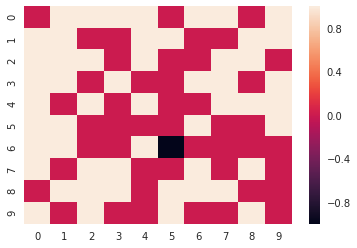

(6, 5)


In [14]:
# lattice initialisation

n=10

#lat = np.zeros([n,n])
lat = (np.random.rand(n,n)<0.5)*1.0
init_lat=lat

vacancy_pos = int(n/2),int(n/2)
vacancy_pos = vacancy_pos[0]+1,vacancy_pos[1]

lat[vacancy_pos] = -1

larger_lat = np.ones([n+2,n+2])*0.5

ax = sns.heatmap(lat[:,:])
plt.show()

print(vacancy_pos)

Initial energy =  -311.5


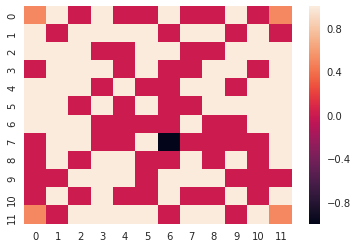

(7, 6)


In [15]:
# return larger lattice for applying periodic boundary conditions

def periodic_bd(lat):
    
    larger_lat = np.ones([n+2,n+2])*0.5
    larger_lat[1:-1,1:-1] = lat
    larger_lat[1:-1,0] = lat[:,-1]
    larger_lat[1:-1,-1] = lat[:,0]
    larger_lat[0,1:-1] = lat[-1,:]
    larger_lat[-1,1:-1] = lat[0,:]
    
    return larger_lat


larger_lat = periodic_bd(lat)

def calc_energy_total(lat):
    
    larger_lat = periodic_bd(lat)
    energy=0
    
    for i in range(n+1):        
        for j in range(n+1):
            
            energy += (larger_lat[i,j]==larger_lat[i+1,j]==0)*pAA + \
            (larger_lat[i,j]==larger_lat[i+1,j]==1)*pBB + \
            ((larger_lat[i,j]!=larger_lat[i+1,j])&(larger_lat[i+1,j]!=0.5))*pAB + \
            (larger_lat[i,j]==larger_lat[i,j+1]==0)*pAA + \
            (larger_lat[i,j]==larger_lat[i,j+1]==1)*pBB + \
            ((larger_lat[i,j]!=larger_lat[i,j+1])&(larger_lat[i,j+1]!=0.5))*pAB
            
    return energy

initial_energy = calc_energy_total(lat)

print("Initial energy = ", initial_energy)

larger_lat = periodic_bd(lat)
vacancy_pos = vacancy_pos[0]+1,vacancy_pos[1]+1

ax = sns.heatmap(larger_lat)
plt.show()
print(vacancy_pos)

In [16]:
def calc_energy_one(pos,larger_lat):
    
    i1 = pos[0]
    j1 = pos[1]
    
    # wrapping to avoid array out of bounds
    if (j1<1):    
        j1=n
        
    if (j1>n):
        j1=1
    
    if (i1<1):    
        i1=n
        
    if (i1>n):
        i1=1
    
    energy = (larger_lat[i1,j1]==larger_lat[i1+1,j1]==0)*pAA + \
    (larger_lat[i1,j1]==larger_lat[i1+1,j1]==1)*pBB + \
    ((larger_lat[i1,j1]!=larger_lat[i1+1,j1])&(larger_lat[i1+1,j1]!=0.5))*pAB + \
    (larger_lat[i1,j1]==larger_lat[i1,j1+1]==0)*pAA + \
    (larger_lat[i1,j1]==larger_lat[i1,j1+1]==1)*pBB + \
    ((larger_lat[i1,j1]!=larger_lat[i1,j1+1])&(larger_lat[i1,j1+1]!=0.5))*pAB + \
    (larger_lat[i1,j1]==larger_lat[i1,j1-1]==0)*pAA + \
    (larger_lat[i1,j1]==larger_lat[i1,j1-1]==1)*pBB + \
    ((larger_lat[i1,j1]!=larger_lat[i1,j1-1])&(larger_lat[i1,j1-1]!=0.5))*pAB + \
    (larger_lat[i1,j1]==larger_lat[i1-1,j1]==0)*pAA + \
    (larger_lat[i1,j1]==larger_lat[i1-1,j1]==1)*pBB + \
    ((larger_lat[i1,j1]!=larger_lat[i1-1,j1])&(larger_lat[i1-1,j1]!=0.5))*pAB
    
    return energy

calc_energy_one((5,5),larger_lat)

-6.0

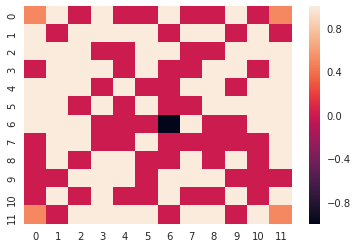

(7, 6)


In [17]:
def swap(pos1,pos2,larger_lat):
    
    #pos1 is vacancy position
    new = np.copy(larger_lat)
    temp = new[pos2]
    new[pos2] = new[pos1]
    new[pos1] = temp
    
    delta_e = (-calc_energy_one(pos1,larger_lat) \
    - calc_energy_one(pos2,larger_lat) \
    + calc_energy_one(pos1,new) \
    + calc_energy_one(pos2,new))
    
    return new,delta_e

up = vacancy_pos[0]-1,vacancy_pos[1]

# moving up
#ax = sns.heatmap(larger_lat)
ax = sns.heatmap(swap(vacancy_pos,up,larger_lat)[0])
plt.show()

print(vacancy_pos)

(6, 6) 0.0


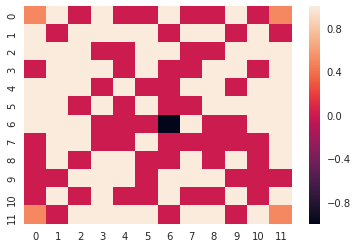

(7, 6)


In [18]:
def iteration(larger_lat,vacancy_pos,kT):
    
    # Finding different paths and their relative kinetics
    
    up = vacancy_pos[0]-1,vacancy_pos[1]
    down = vacancy_pos[0]+1,vacancy_pos[1]
    right = vacancy_pos[0],vacancy_pos[1]+1
    left = vacancy_pos[0],vacancy_pos[1]-1
    
    lat_up,e_up = swap(vacancy_pos,up,larger_lat)
    lat_down,e_down = swap(vacancy_pos,down,larger_lat)
    lat_right,e_right = swap(vacancy_pos,right,larger_lat)
    lat_left,e_left = swap(vacancy_pos,left,larger_lat)
    
    positions = [up,down,right,left]
    energies = np.array([e_up,e_down,e_right,e_left])
    rates = np.exp(-energies/kT)
    lats = [lat_up,lat_down,lat_right,lat_left]
    
    # Choosing which path to take
    
    cum_rates = np.cumsum(rates)
    rand = np.random.rand()*cum_rates[-1]
    index = np.where(np.array(cum_rates>rand) ==True)[0][0]
    
    # Apply periodic boundary conditions.
    
    if (positions[index][0]<1): 
        
        x = n
        y = positions[index][1]
        positions[index] = x,y
        lats[index][positions[index]] = -1
        
    if (positions[index][1]<1): 
        
        x = positions[index][0]
        y = n
        positions[index]= x,y
        lats[index][positions[index]] = -1
        
    if (positions[index][0]>n): 
        
        x = 1
        y = positions[index][1]
        positions[index] = x,y
        lats[index][positions[index]] = -1
    
    if (positions[index][1]>n): 
        
        x = positions[index][0]
        y = 1
        positions[index]= x,y
        lats[index][positions[index]] = -1
        
    lats[index] = periodic_bd(lats[index][1:-1,1:-1])
    
    # return the vacancy position, new lattice and change in energy
    
    return lats[index], positions[index], energies[index]
    

res = iteration(larger_lat,vacancy_pos,0.01)
ax = sns.heatmap(res[0])
print(res[1],res[2])
plt.show()
print(vacancy_pos)

In [30]:
# complete run

# lattice initialisation

n=15

#lat = np.zeros([n,n])
lat = (np.random.rand(n,n)<0.5)*1.0
init_lat=lat

vacancy_pos = 2,2
vacancy_pos = vacancy_pos[0]+1,vacancy_pos[1]

lat[vacancy_pos] = -1

larger_lat = np.ones([n+2,n+2])*0.5
larger_lat = periodic_bd(lat)
vacancy_pos = vacancy_pos[0]+1,vacancy_pos[1]+1



total_time = 10000
record = np.zeros([total_time,n,n])
#record = np.zeros([n+2,n+2,total_time])
energies = np.zeros(total_time)
current_energy=0

kT = 0.1     # Fake Temperature


for i in range(total_time):
    
    global larger_lat
    record[i,:,:] = larger_lat[1:-1,1:-1]
    #record[:,:,i] = larger_lat[:,:]
    energies[i] = current_energy
    #print(i,vacancy_pos[0],vacancy_pos[1])
    larger_lat,vacancy_pos,delta_e = iteration(larger_lat,vacancy_pos,kT)
    current_energy+= delta_e
    

In [31]:
def heat(x):
    ax = sns.heatmap(record[x,:,:])
    plt.show()


interact(heat,x=(0,record.shape[0]-1,1))

A Jupyter Widget

<function __main__.heat>

In [32]:
imageio.mimsave('anim.gif',record)

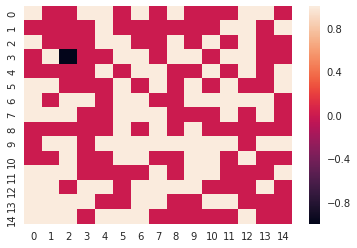

In [33]:
ax = sns.heatmap(record[0,:,:])

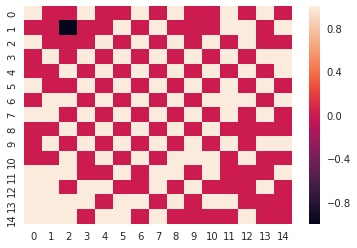

In [35]:
ax = sns.heatmap(record[-1,:,:])

ValueError: Invalid file object: <_io.BufferedReader name=50>

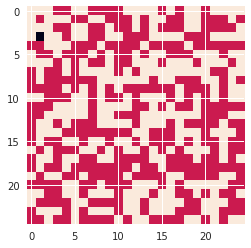

In [72]:
# animation_shiz

fig = plt.figure()

def init():
    
    return sns.heatmap(record[:,:,0])

#def animate(i):
    
#    return [plt.imshow(record[:,:,i]), ]

#anim.save('animation.gif', writer='imagemagick', fps=2)

#im = plt.imshow(record[:,:,0], animated=True)

anim = animation.FuncAnimation(fig, animate)
anim
